# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/LSTMx/"

df = pd.read_csv(data_path)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


In [3]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [4]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

In [5]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]

In [6]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [7]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [8]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [9]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh"]]
test_xs_df = test_df["Holiday"]

# Dataset and DataLoader

In [10]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [11]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
data_dir = "datasets/infuluenza/vecLSTMx/"
exp_dir = "datasets/infuluenza/LSTMx/"

In [12]:
seq_length = 52

train_Xs = np.load(data_dir + "train_X_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_y_" + str(seq_length) + "w.npy")

In [13]:
train_Xs.shape, train_ys.shape

((728, 52, 4), (728, 1, 4))

In [14]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [15]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [16]:
train_Xs = np.concatenate([train_Xs[:,:,0:1], train_Xs[:,:,-2:-1]], axis = 2)
val_Xs = np.concatenate([val_Xs[:,:,0:1], val_Xs[:,:,-2:-1]], axis = 2)

In [17]:
train_ys = np.concatenate([train_ys[:,:,0:1], train_ys[:,:,-2:-1]], axis = 2)
val_ys = np.concatenate([val_ys[:,:,0:1], val_ys[:,:,-2:-1]], axis = 2)

In [18]:
train_Xs.shape, val_Xs.shape, train_ys.shape, val_ys.shape

((582, 52, 2), (146, 52, 2), (582, 1, 2), (146, 1, 2))

In [19]:
trn_xs_tensor = torch.Tensor(train_Xs)
trn_ys_tensor = torch.Tensor(train_ys)

val_xs_tensor = torch.Tensor(val_Xs)
val_ys_tensor = torch.Tensor(val_ys)

In [20]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([582, 52, 2]),
 torch.Size([582, 1, 2]),
 torch.Size([146, 52, 2]),
 torch.Size([146, 1, 2]))

In [21]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [22]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
1 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
2 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
3 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
4 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
5 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
6 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
7 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
8 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
9 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
10 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
11 torch.Size([32, 52, 2]) torch.Size([32, 1, 2])


In [23]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
1 torch.Size([50, 52, 2]) torch.Size([50, 1, 2])
2 torch.Size([46, 52, 2]) torch.Size([46, 1, 2])


In [24]:
#train_ts_df = train_df["Flucases"]
#train_ys_df = train_df[["Tempave", "Rh"]]
#train_xs_df = train_df["Holiday"]

#train_np = np.concatenate([train_ts_np.reshape(-1,1), train_ys_np, train_xs_np.reshape(-1,1)], axis = 1)

# LSTM model

In [25]:
class cLSTM(nn.Module):
    def __init__(self, input_size = 4, hidden_size=32, cond_size = 1, output_size=4, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cond_size = cond_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.cfc1 = nn.Linear(self.cond_size, int(self.hidden_size / 2))
        self.cfc2 = nn.Linear(int(self.hidden_size / 2), int(self.hidden_size / 4))
        
        self.fc1 = nn.Linear(int(self.hidden_size / 4) + self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x, cin):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
        
        ch1 = self.relu(self.cfc1(cin))
        ch2 = self.cfc2(ch1)
        
        h_list = [outs, ch2]
        h1 = torch.cat(h_list, dim=1)
        h2 = self.relu(self.fc1(h1))
        y = self.relu(self.fc2(h2))
        
        return y

In [26]:
model = cLSTM(input_size = 2, hidden_size = 16, cond_size = 1, output_size = 1, num_layers = 1)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [27]:
model

cLSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(2, 16, dropout=0.2)
  (cfc1): Linear(in_features=1, out_features=8, bias=True)
  (cfc2): Linear(in_features=8, out_features=4, bias=True)
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

## Prediction

In [28]:
batch_0x = list(trn_loader)[0][0]
batch_0c = list(trn_loader)[0][1]

In [29]:
batch_0x.shape, batch_0c.shape

(torch.Size([50, 52, 2]), torch.Size([50, 1, 2]))

In [30]:
batch_0c = torch.reshape(batch_0c[:,:,-1], (batch_0c.shape[0], 1))

In [31]:
preds = model(batch_0x, batch_0c)

In [32]:
batch_0c.shape

torch.Size([50, 1])

In [33]:
preds = model(batch_0x, batch_0c)

In [34]:
preds.shape

torch.Size([50, 1])

## Train

In [35]:
model.cuda()

cLSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(2, 16, dropout=0.2)
  (cfc1): Linear(in_features=1, out_features=8, bias=True)
  (cfc2): Linear(in_features=8, out_features=4, bias=True)
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [36]:
criterion = nn.MSELoss(reduction='mean').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [37]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()
                input_c = torch.reshape(trues[:,:,-1], (trues.shape[0], 1))
                true_y = torch.reshape(trues[:,:,0:1], (trues.shape[0], 1))

            pred = model(inputs, input_c)
            pred = pred.reshape(true_y.shape)
            loss = criterion(pred, true_y)
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [38]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        input_c = torch.reshape(trues[:,:,-1], (trues.shape[0], 1))
        true_y = torch.reshape(trues[:,:,0:1], (trues.shape[0], 1))
        
        optimizer.zero_grad()
        
        pred = model(inputs, input_c)
        pred = pred.reshape(true_y.shape)
        loss = criterion(pred, true_y)
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.8178350801269213 Val loss:  1.041379729906718
epoch:  1 Train loss:  0.734739085038503 Val loss:  0.9403441945711771
epoch:  2 Train loss:  0.692900113761425 Val loss:  0.8607951601346334
epoch:  3 Train loss:  0.6173715765277544 Val loss:  0.7813798189163208
epoch:  4 Train loss:  0.5715281094113985 Val loss:  0.6937846740086874
epoch:  5 Train loss:  0.49935880427559215 Val loss:  0.5917481879393259
epoch:  6 Train loss:  0.427276944120725 Val loss:  0.4796115756034851
epoch:  7 Train loss:  0.3306778433422248 Val loss:  0.3568186362584432
epoch:  8 Train loss:  0.2560959442829092 Val loss:  0.25160611669222516
epoch:  9 Train loss:  0.15560114802792668 Val loss:  0.17322360972563425
epoch:  10 Train loss:  0.11161013320088387 Val loss:  0.14829126993815103
epoch:  11 Train loss:  0.10256377266099055 Val loss:  0.14951372891664505
epoch:  12 Train loss:  0.11315217629695933 Val loss:  0.1470922032992045
epoch:  13 Train loss:  0.09849146629373233 Val loss:  0

epoch:  113 Train loss:  0.0874743415042758 Val loss:  0.17159593850374222
epoch:  114 Train loss:  0.08679239890382935 Val loss:  0.1698240985472997
epoch:  115 Train loss:  0.09206591934586565 Val loss:  0.17067335546016693
epoch:  116 Train loss:  0.08914276057233413 Val loss:  0.1695044885079066
epoch:  117 Train loss:  0.08735898393206298 Val loss:  0.16969612737496695
epoch:  118 Train loss:  0.08944710437208414 Val loss:  0.16808310399452844
epoch:  119 Train loss:  0.08958845833937328 Val loss:  0.17189538230498633
epoch:  120 Train loss:  0.08866813313215971 Val loss:  0.17028685410817465
epoch:  121 Train loss:  0.09020443726330996 Val loss:  0.1695320705572764
epoch:  122 Train loss:  0.0898237753038605 Val loss:  0.17139295240243277
epoch:  123 Train loss:  0.09004277115066846 Val loss:  0.1727899064620336
epoch:  124 Train loss:  0.08824013127014041 Val loss:  0.17117542773485184
epoch:  125 Train loss:  0.0905597818394502 Val loss:  0.17019234846035639
epoch:  126 Train l

epoch:  222 Train loss:  0.0878892691495518 Val loss:  0.18643924842278162
epoch:  223 Train loss:  0.08860017972377439 Val loss:  0.18339856217304865
epoch:  224 Train loss:  0.08724115773414572 Val loss:  0.19241677224636078
epoch:  225 Train loss:  0.08560255666573842 Val loss:  0.18544072906176248
epoch:  226 Train loss:  0.0847999545900772 Val loss:  0.1877149442831675
epoch:  227 Train loss:  0.08671095222234726 Val loss:  0.18440700322389603
epoch:  228 Train loss:  0.08867252788816889 Val loss:  0.18484885493914285
epoch:  229 Train loss:  0.08526245970278978 Val loss:  0.1837751865386963
epoch:  230 Train loss:  0.08488151493171851 Val loss:  0.18793581426143646
epoch:  231 Train loss:  0.08565472268188994 Val loss:  0.1833385800321897
epoch:  232 Train loss:  0.0873717258994778 Val loss:  0.18494477619727454
epoch:  233 Train loss:  0.08733076730277389 Val loss:  0.18664322793483734
epoch:  234 Train loss:  0.08421906021734078 Val loss:  0.1830629582206408
epoch:  235 Train l

epoch:  334 Train loss:  0.08439080401634176 Val loss:  0.19511596858501434
epoch:  335 Train loss:  0.08470804686658084 Val loss:  0.19163631896177927
epoch:  336 Train loss:  0.08518498701353867 Val loss:  0.1981299767891566
epoch:  337 Train loss:  0.08246541706224282 Val loss:  0.19242868820826212
epoch:  338 Train loss:  0.08505056456973155 Val loss:  0.19743790725866953
epoch:  339 Train loss:  0.08946685974175732 Val loss:  0.19671491781870523
epoch:  340 Train loss:  0.08072220254689455 Val loss:  0.19353928168614706
epoch:  341 Train loss:  0.08193778456188738 Val loss:  0.19553899268309274
epoch:  342 Train loss:  0.08210975599164765 Val loss:  0.19783701996008554
epoch:  343 Train loss:  0.08295405306853354 Val loss:  0.19622145096460977
epoch:  344 Train loss:  0.08330517223415275 Val loss:  0.20105774700641632
epoch:  345 Train loss:  0.08325611520558596 Val loss:  0.19489560524622598
epoch:  346 Train loss:  0.08133624866604805 Val loss:  0.20292886594931284
epoch:  347 T

epoch:  446 Train loss:  0.07996636885218322 Val loss:  0.2007396419843038
epoch:  447 Train loss:  0.07951114078362782 Val loss:  0.20765753090381622
epoch:  448 Train loss:  0.08071528701111674 Val loss:  0.20675506194432577
epoch:  449 Train loss:  0.082310065239047 Val loss:  0.20617903272310892
epoch:  450 Train loss:  0.0805029864422977 Val loss:  0.20256882905960083
epoch:  451 Train loss:  0.08678936430563529 Val loss:  0.20535395542780557
epoch:  452 Train loss:  0.08115870893622439 Val loss:  0.20764024058977762
epoch:  453 Train loss:  0.08699654027198751 Val loss:  0.20973575611909231
epoch:  454 Train loss:  0.08112328251202901 Val loss:  0.20828144252300262
epoch:  455 Train loss:  0.07998645367721717 Val loss:  0.2090257207552592
epoch:  456 Train loss:  0.07967458028967182 Val loss:  0.20542173087596893
epoch:  457 Train loss:  0.08113107038661838 Val loss:  0.20352557798226675
epoch:  458 Train loss:  0.08127788244746625 Val loss:  0.20328453679879507
epoch:  459 Train

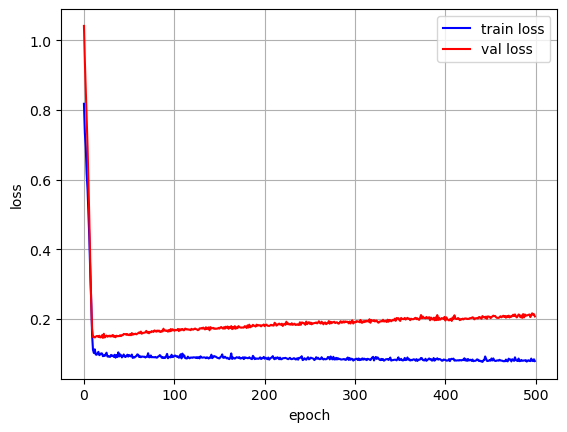

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [40]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(21, 0.1458639254172643)

In [41]:
save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"

model = torch.load(save_model_path)

### Scatter plot

In [42]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        print(input_c.shape, input_c.shape)
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

torch.Size([1, 1]) torch.Size([1, 1])
0
torch.Size([1, 1]) torch.Size([1, 1])
1
torch.Size([1, 1]) torch.Size([1, 1])
2
torch.Size([1, 1]) torch.Size([1, 1])
3
torch.Size([1, 1]) torch.Size([1, 1])
4
torch.Size([1, 1]) torch.Size([1, 1])
5
torch.Size([1, 1]) torch.Size([1, 1])
6
torch.Size([1, 1]) torch.Size([1, 1])
7
torch.Size([1, 1]) torch.Size([1, 1])
8
torch.Size([1, 1]) torch.Size([1, 1])
9
torch.Size([1, 1]) torch.Size([1, 1])
10
torch.Size([1, 1]) torch.Size([1, 1])
11
torch.Size([1, 1]) torch.Size([1, 1])
12
torch.Size([1, 1]) torch.Size([1, 1])
13
torch.Size([1, 1]) torch.Size([1, 1])
14
torch.Size([1, 1]) torch.Size([1, 1])
15
torch.Size([1, 1]) torch.Size([1, 1])
16
torch.Size([1, 1]) torch.Size([1, 1])
17
torch.Size([1, 1]) torch.Size([1, 1])
18
torch.Size([1, 1]) torch.Size([1, 1])
19
torch.Size([1, 1]) torch.Size([1, 1])
20
torch.Size([1, 1]) torch.Size([1, 1])
21
torch.Size([1, 1]) torch.Size([1, 1])
22
torch.Size([1, 1]) torch.Size([1, 1])
23
torch.Size([1, 1]) torch.S

torch.Size([1, 1]) torch.Size([1, 1])
271
torch.Size([1, 1]) torch.Size([1, 1])
272
torch.Size([1, 1]) torch.Size([1, 1])
273
torch.Size([1, 1]) torch.Size([1, 1])
274
torch.Size([1, 1]) torch.Size([1, 1])
275
torch.Size([1, 1]) torch.Size([1, 1])
276
torch.Size([1, 1]) torch.Size([1, 1])
277
torch.Size([1, 1]) torch.Size([1, 1])
278
torch.Size([1, 1]) torch.Size([1, 1])
279
torch.Size([1, 1]) torch.Size([1, 1])
280
torch.Size([1, 1]) torch.Size([1, 1])
281
torch.Size([1, 1]) torch.Size([1, 1])
282
torch.Size([1, 1]) torch.Size([1, 1])
283
torch.Size([1, 1]) torch.Size([1, 1])
284
torch.Size([1, 1]) torch.Size([1, 1])
285
torch.Size([1, 1]) torch.Size([1, 1])
286
torch.Size([1, 1]) torch.Size([1, 1])
287
torch.Size([1, 1]) torch.Size([1, 1])
288
torch.Size([1, 1]) torch.Size([1, 1])
289
torch.Size([1, 1]) torch.Size([1, 1])
290
torch.Size([1, 1]) torch.Size([1, 1])
291
torch.Size([1, 1]) torch.Size([1, 1])
292
torch.Size([1, 1]) torch.Size([1, 1])
293
torch.Size([1, 1]) torch.Size([1, 

torch.Size([1, 1]) torch.Size([1, 1])
542
torch.Size([1, 1]) torch.Size([1, 1])
543
torch.Size([1, 1]) torch.Size([1, 1])
544
torch.Size([1, 1]) torch.Size([1, 1])
545
torch.Size([1, 1]) torch.Size([1, 1])
546
torch.Size([1, 1]) torch.Size([1, 1])
547
torch.Size([1, 1]) torch.Size([1, 1])
548
torch.Size([1, 1]) torch.Size([1, 1])
549
torch.Size([1, 1]) torch.Size([1, 1])
550
torch.Size([1, 1]) torch.Size([1, 1])
551
torch.Size([1, 1]) torch.Size([1, 1])
552
torch.Size([1, 1]) torch.Size([1, 1])
553
torch.Size([1, 1]) torch.Size([1, 1])
554
torch.Size([1, 1]) torch.Size([1, 1])
555
torch.Size([1, 1]) torch.Size([1, 1])
556
torch.Size([1, 1]) torch.Size([1, 1])
557
torch.Size([1, 1]) torch.Size([1, 1])
558
torch.Size([1, 1]) torch.Size([1, 1])
559
torch.Size([1, 1]) torch.Size([1, 1])
560
torch.Size([1, 1]) torch.Size([1, 1])
561
torch.Size([1, 1]) torch.Size([1, 1])
562
torch.Size([1, 1]) torch.Size([1, 1])
563
torch.Size([1, 1]) torch.Size([1, 1])
564
torch.Size([1, 1]) torch.Size([1, 

In [43]:
np.array(trues_list).shape, np.array(preds_list).shape

((582, 1, 1), (582, 1, 1))

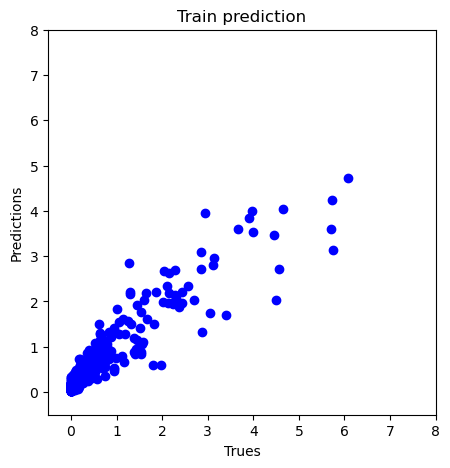

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [45]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        print(input_c.shape, input_c.shape)
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

torch.Size([1, 1]) torch.Size([1, 1])
0
torch.Size([1, 1]) torch.Size([1, 1])
1
torch.Size([1, 1]) torch.Size([1, 1])
2
torch.Size([1, 1]) torch.Size([1, 1])
3
torch.Size([1, 1]) torch.Size([1, 1])
4
torch.Size([1, 1]) torch.Size([1, 1])
5
torch.Size([1, 1]) torch.Size([1, 1])
6
torch.Size([1, 1]) torch.Size([1, 1])
7
torch.Size([1, 1]) torch.Size([1, 1])
8
torch.Size([1, 1]) torch.Size([1, 1])
9
torch.Size([1, 1]) torch.Size([1, 1])
10
torch.Size([1, 1]) torch.Size([1, 1])
11
torch.Size([1, 1]) torch.Size([1, 1])
12
torch.Size([1, 1]) torch.Size([1, 1])
13
torch.Size([1, 1]) torch.Size([1, 1])
14
torch.Size([1, 1]) torch.Size([1, 1])
15
torch.Size([1, 1]) torch.Size([1, 1])
16
torch.Size([1, 1]) torch.Size([1, 1])
17
torch.Size([1, 1]) torch.Size([1, 1])
18
torch.Size([1, 1]) torch.Size([1, 1])
19
torch.Size([1, 1]) torch.Size([1, 1])
20
torch.Size([1, 1]) torch.Size([1, 1])
21
torch.Size([1, 1]) torch.Size([1, 1])
22
torch.Size([1, 1]) torch.Size([1, 1])
23
torch.Size([1, 1]) torch.S

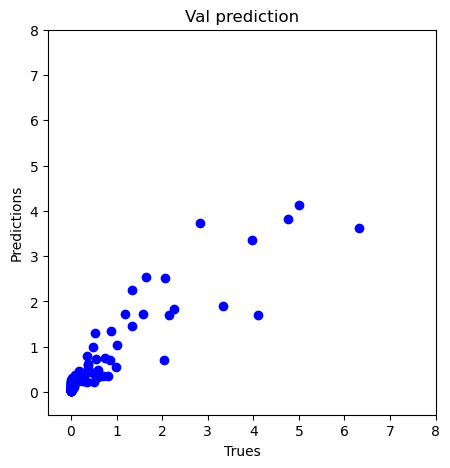

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [47]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [48]:
train_np.shape, test_np.shape

((780, 4), (260, 4))

In [49]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [50]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [51]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [52]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

In [53]:
test_all_np.shape

(260, 4)

In [54]:
test_np[:,-1].shape, test_scaled_ts.shape, test_scaled_ys.shape, test_np.shape

((260,), (260,), (260, 2), (260, 4))

### 1. Prediction based on results from 40 days ago

In [55]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [56]:
test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [57]:
test_Xs = np.concatenate([test_Xs[:,:,0:1], test_Xs[:,:,-2:-1]], axis = 2)
test_ys = np.concatenate([test_ys[:,:,0:1], test_ys[:,:,-2:-1]], axis = 2)

In [58]:
tst_xs_tensor = torch.Tensor(test_Xs)
tst_ys_tensor = torch.Tensor(test_ys)

In [59]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [60]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207


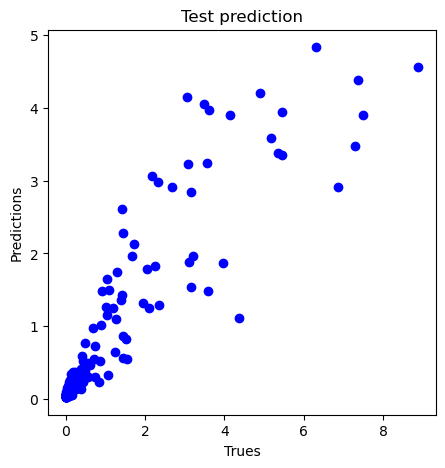

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [62]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [63]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

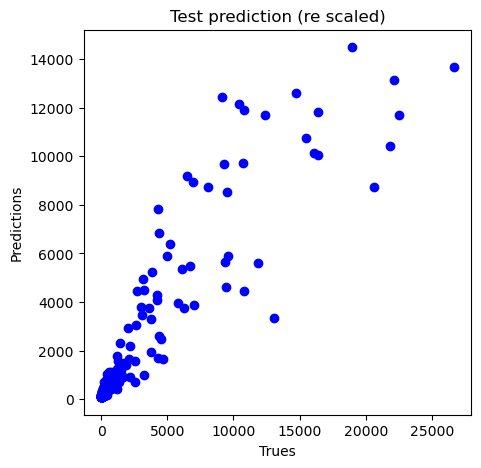

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [65]:
tst_preds.shape

(208, 1)

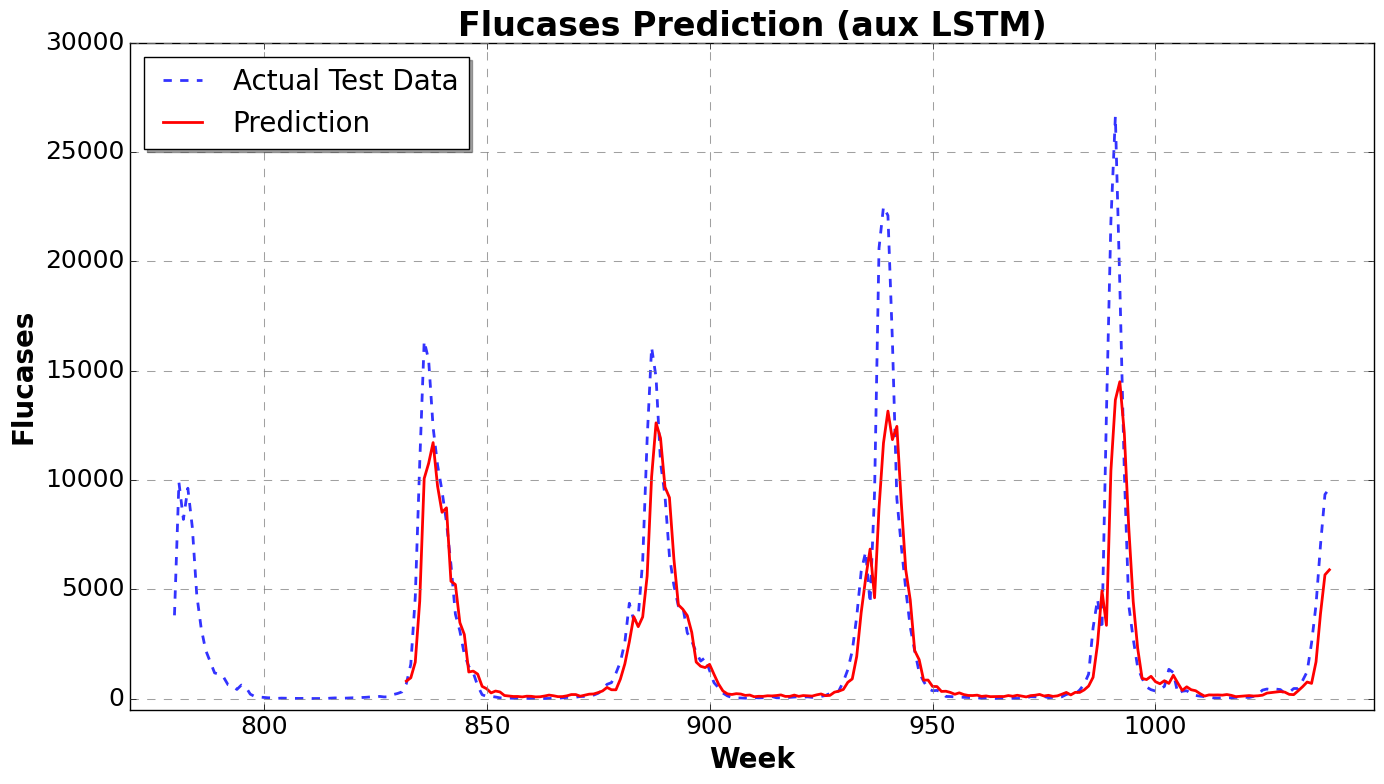

In [66]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=2, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=2, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Flucases Prediction (aux LSTM)", fontsize=24, fontweight='bold')

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
plt.savefig("Flucases Prediction (aux LSTM).jpg", dpi=200, bbox_inches='tight', format='jpg')
plt.show()

In [67]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [68]:
reg_metric(test_np[seq_length:,0], tst_preds[:,0], "Flucases")

Flucases
MSE : 5446750.351827526.
RMSE : 2333.8274040355955.
MAE : 977.331654218527.
R2 : 0.7741182786059294.
pearson : 0.9132541130941337 2.7905680947429687e-82
